# Debugging Conditional Forecasts

We need to make sure that we're getting the correct outcomes for the conditional forecasts. Early evidence suggests that we are not due to the fact that we have ballooning uncertainty.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\us57144\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
import os
import tempfile
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import GtmmData
import bvar

In [3]:
sns.set_style('whitegrid')
sns.set_palette('deep')

FRED_KEY = os.environ['FRED_KEY']
FORCE_RELOAD = True
BASE_PATH = os.path.join(tempfile.gettempdir(), 'bvar-usage')

In [4]:
model_name = '3-var'
series = ['CPIAUCSL', 'FEDFUNDS', 'PAYEMS']
model_base_path = os.path.join(BASE_PATH, model_name)
data_path = os.path.join(model_base_path, 'data.pkl')
model_path = os.path.join(model_base_path, 'model.pkl')
if not os.path.exists(model_base_path):
    os.makedirs(model_base_path)
    
if not os.path.exists(data_path) or FORCE_RELOAD:
  fred_data0 = GtmmData.FredData(apiKey=FRED_KEY)
  fred_data0.getFredData(ids=series) # Download data
  fred_data0.setTrans(['CPIAUCSL', 'PAYEMS'], 'log') # Make these variables logs
#   fred_data0.setTrans('FEDFUNDS', 'log') # Try this out
  fred_data = fred_data0.format(balanced=True, freq='coarse',trim=[pd.Timestamp('1959-01-01'), pd.Timestamp('2019-01-01', freq='M')]) # Format it
  fred_data.to_pickle(data_path)
else:
  fred_data = GtmmData.read_pickle(data_path)

In [5]:
bvs = bvar.core.BVAR(
  data=fred_data.data,
  lags=13,
  prior_spec='DIO_MN_SOC',
  hyperparameters={'Lambda': 0.45, 'mu': 0.214, 'delta': 0.124, 'dof': 14}
)

## The Issue

Now let's demonstrate the basic issue: the size of the errors balloon for some pretty modest conditions.

In [6]:
conditional_forecast_script = '''
eqn EQ0 = PAYEMS[+1];
eqn EQ1 = FEDFUNDS[+1];
eqn EQ2 = FEDFUNDS[+2];

mean EQ0 = 11.922209936681169; // = log(15074) = Jan. 2019 Nonfarm employment
mean EQ1 = 2.40; // log(2.40) = Jan 2019 Effective Fed funds rate
mean EQ2 = 2.38; // Guessing that the fed will not change rates in February => close to constant FFNDs

std EQ0 = 1e-1;
std EQ1 = 1.1e-1;
std EQ2 = 1.2e-1;
'''

In [7]:
fc = bvs.forecast(
    n_periods = 12,
    kind = 'apw',
    hierarchical = False,
    script = conditional_forecast_script,
    iters = 2000,
    chains = 4
  )

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E69AB38>,
       dtype=object))

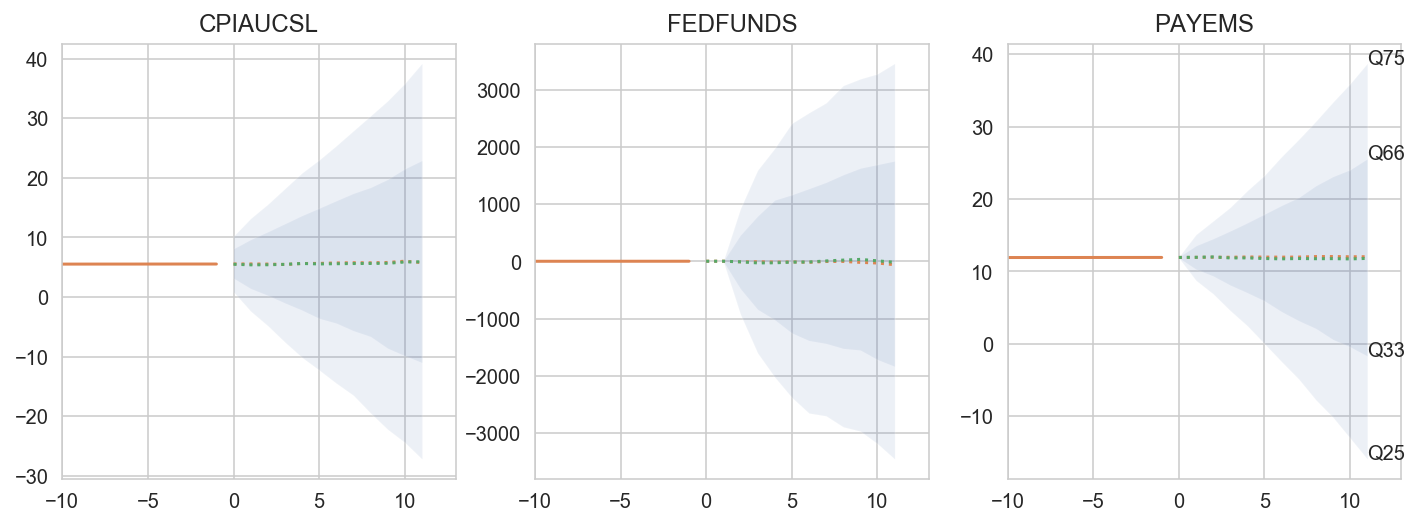

In [8]:
fc.plot()

In [9]:
fc.table()

CPIAUCSL                                                                   \
        Mean        Q25        Q33       Q50        Q66        Q75         SD   
0   5.492490   0.875061   3.169212  5.547207   8.092211  10.201027  10.165800   
1   5.394283  -2.367369   1.436850  5.551836   9.638947  13.186324  17.120632   
2   5.408750  -4.809031   0.293789  5.528671  10.935393  15.559426  22.907483   
3   5.476680  -7.562915  -0.990487  5.460864  12.300924  18.198132  28.246484   
4   5.623194 -10.131975  -2.190721  5.619511  13.667489  20.828463  33.521954   
5   5.546416 -12.252470  -3.574075  5.639882  14.895643  23.001258  38.746669   
6   5.581483 -14.460884  -4.374071  5.717293  16.159674  25.392325  44.174692   
7   5.613496 -16.490943  -5.647691  5.755443  17.388834  27.903984  49.411796   
8   5.627369 -19.466820  -6.615704  5.741161  18.380366  30.401483  54.863843   
9   5.658766 -22.205153  -8.593998  5.798889  19.735038  32.927000  60.649840   
10  5.871107 -24.400879  -9.835128  6.010792  21.511863  35.847601  66.656701   
11  5.913465 -27.171841 -10.985810  5.769348  22.904657  39.200440  73.337927   

     FEDFUNDS                             ...                               \
         Mean          Q25          Q33   ...             Q75           SD   
0    2.401286     2.329162     2.356967   ...        2.475683     0.109562   
1    2.381062     2.302415     2.332996   ...        2.462614     0.119563   
2   -7.836124  -925.035951  -477.513641   ...      922.996409  2065.873189   
3  -27.341083 -1600.672131  -838.235028   ...     1593.826334  3490.605142   
4  -25.706204 -2023.135720 -1020.310109   ...     1976.801902  4495.154388   
5  -13.558671 -2379.563663 -1251.878133   ...     2414.020511  5208.321245   
6  -11.356173 -2653.949737 -1383.703745   ...     2600.439124  5762.199086   
7    7.574173 -2702.463410 -1435.091907   ...     2773.059877  6234.290004   
8   22.337994 -2894.909616 -1521.952767   ...     3076.000751  6654.200620   
9   34.841054 -2969.289207 -1550.387197   ...     3193.057670  6978.436806   
10   9.373607 -3188.769168 -1716.532710   ...     3280.751421  7314.629133   
11 -16.119261 -3455.722574 -1835.836559   ...     3462.795648  7738.012899   

       PAYEMS                                                         \
         Mean        Q25        Q33        Q50        Q66        Q75   
0   11.921816  11.855614  11.880196  11.920697  11.963079  11.988199   
1   11.936324   8.759210  10.306737  11.937571  13.531760  15.077820   
2   11.992213   6.905851   9.379202  11.948189  14.506437  16.949973   
3   11.850025   4.584845   8.108923  11.948359  15.576750  18.838617   
4   11.856579   2.484105   7.055508  11.986611  16.702210  21.154200   
5   11.764425   0.007495   5.929463  11.970629  17.901548  23.259075   
6   11.723146  -2.477550   4.442342  11.961860  19.104818  25.857278   
7   11.765973  -4.880963   3.186261  11.971879  20.195727  28.234134   
8   11.740107  -7.753346   2.116845  12.039736  21.825397  30.746570   
9   11.751560 -10.161366   0.590241  12.044420  23.094756  33.391937   
10  11.712832 -13.032004  -0.421179  12.014188  24.035227  35.921519   
11  11.785056 -15.918763  -1.687638  12.018545  25.542641  38.729644   

              forecast  
           SD           
0    0.099999        1  
1    7.094036        1  
2   11.172436        1  
3   15.672765        1  
4   20.509156        1  
5   25.810779        1  
6   31.204954        1  
7   36.761645        1  
8   42.500810        1  
9   48.187327        1  
10  54.186238        1  
11  59.950624        1  

[12 rows x 22 columns]

There is clearly something wrong with these forecasts.

The specified distributions are hitting the right moments. They also appear to be close to normal:

In [10]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

for ax, idx,ttl in zip(axes, [1,2,4], ['FEDFUNDS[+1]', 'PAYEMS[+1]', 'FEDFUNDS[+2]']):
  sns.distplot(fc.raw_output[:,idx], ax=ax)
  ax.set_title(ttl)

## Checking objects

### Checking the moment matrices

The script parser is rather elaborate. There could be a problem there.

`f` contains the means of each equation. We should see the means of the each equation here in order:

In [11]:
fc.f

array([11.92220994,  2.4       ,  2.38      ])

`Omega_f` contains the covariance matrix of all of the equations. The diagonal elements should be the squares of the `std`s specified in the script. The off-diagonals are computed automatically using a heuristic. These should just not look to crazy or large:

In [12]:
fc.Omega_f

array([[ 0.01      , -0.00297401, -0.00329426],
       [-0.00297401,  0.0121    ,  0.01306796],
       [-0.00329426,  0.01306796,  0.0144    ]])

`Xi` contains the equation matrix that converts the forecast vector into the equations:

In [13]:
fc.Xi

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

All of these objects look to be okay.

### ❌ Inspecting the raw data

Let's plot the raw data to see if there is anything odd going on there. All of the randomness in the sampler is iid across periods so we should basically see a random walk.

In [14]:
rd = fc.raw_output
n_periods = fc.n_periods

fig, axes = plt.subplots(n_periods, len(series), sharex=True, figsize=(4*len(series), 2*n_periods))
axes = axes.flatten()

ff = 1
for ii,(ax,s) in enumerate(zip(axes, np.tile(series,[fc.n_periods]))):
  
  ax.plot(rd[:,ii].T, alpha=0.25)
  ax.set_title('{}[+{}]'.format(s,ff))
  
  if ii != 0 and (ii+1) % len(series) == 0:
    ff += 1

This is **not** what was expected!!! We shouldn't see the variance of the draws increase across iterations.

#### Distinguishing between stochastic and non-stochastic components

Below, I replicate a non-jit version of the forecast method. The main difference is that it outputs three different outputs for the overall, non-stochastic, and stochastic parts of the prediction.

In [15]:
from bvar.core.jit_ops import apw_objects as apw
from bvar.core.jit_ops import utils as jit_utils

def apw_nonhier_split(
  y, Xi, f, Omega_f,
  vecB_mean, B_XpXomega_inv, Sigma_scale,
  Sigma_dof, p, n, n_periods, samples
):
  # Make certain that input is C-contiguous

  # Size: [samples, n, n]
  Sigma_draws = jit_utils.random_invwishart(
    Sigma_scale, Sigma_dof, False, samples
  )
  # Size: [samples, n*k]
  B_eps_draws = np.random.randn(samples, n * (n * p + 1))
  # Size: [samples, n*n_periods]
  eps_draws = np.random.randn(samples, n * n_periods)
  M_cast = np.zeros((n * n_periods, n * n_periods))
  
  out = np.empty((samples, n*n_periods))
  out_stoch = np.empty((samples, n*n_periods))
  out_nonstoch = np.empty((samples, n*n_periods))

  for ii in range(samples):

    # Setup: Posterior
    #   Draw `Sigma` given y [done in bulk above]

    #   Set covariance of B [With Cholesky Transform]
    #   Size: [n*k, n*k], (k = n*p+1)
    B_cov = np.linalg.cholesky(jit_utils.kron(Sigma_draws[ii], B_XpXomega_inv))

    #   Draw B given Covariance/Sigma
    vecB = vecB_mean + np.dot(B_cov, B_eps_draws[ii])

    # Forecast Matrices:
    #   Set `b`
    B = apw.B_pad(vecB=vecB, p=p, n=n, n_periods=n_periods)
    C = jit_utils.vecB_to_C(vecB=vecB, p=p, n=n)

    b = apw.b(
      y=y,
      C=C,
      B=B,
      n=n,
      p=p,
      n_periods=n_periods,
      out=np.zeros((n_periods * n))
    )

    #   Set `M`
    # TODO: There is a way to exclude a cholesky within `M` when drawing the `Sigma`s. So edit `M` to exclude this and update other files that depend on it.
    M = apw.M(
      B=B,
      sigma=Sigma_draws[ii],
      p=p,
      n=n,
      n_periods=n_periods,
      out=M_cast
    )

    # Draw `eps`: The
    #   Preliminary Objects
    D = apw.D(Xi=Xi, M=M)
    Dhat = apw.Dhat(D=D)
    Dstar = apw.Dstar(D=D)
    #   Set E[eps]
    mu_eps = np.dot(Dstar, f) - np.dot(Dstar, np.dot(Xi, b))
    #   Set Cov(eps)
    cov_eps = np.dot(Dstar, np.dot(Omega_f,
                                   Dstar.T)) + np.dot(Dhat.T, Dhat)
    #   Combine
    eps = mu_eps + np.dot(np.linalg.cholesky(cov_eps), eps_draws[ii])

    # Append to output objects
    out[ii] = b + np.dot(M, eps)
    out_stoch[ii] = b
    out_nonstoch[ii] = np.dot(M, eps)

  return out, out_stoch, out_nonstoch

In [16]:
graph = bvs.graph

# Set up the inputs to main
call_inputs = {
  'y':
    graph.data[graph.T0 - graph.dims['p']:graph.T0],
  'Xi':
    fc.Xi,
  'f':
    fc.f,
  'Omega_f':
    fc.Omega_f,
  'vecB_mean':
    jit_utils.blockB_to_vecB(graph._post['B_mean']),
  'B_XpXomega_inv':
    np.ascontiguousarray(graph._post['B_XpXomega_inv']),
  'Sigma_scale':
    graph._post['Sigma_scale'],
  'Sigma_dof':
    graph._post['Sigma_dof'],
  'p':
    fc.dims['p'],
  'n':
    fc.dims['n'],
  'n_periods':
    fc.n_periods,
  'samples':
    fc.iters,
}

# # Run main
out, out_stoch, out_non_stoch = apw_nonhier_split(
  **call_inputs
)

In [17]:
n_periods = fc.n_periods

fig, axes = plt.subplots(n_periods, len(series), sharex=True, figsize=(4*len(series), 2*n_periods))
axes = axes.flatten()

ff = 1
for ii,(ax,s) in enumerate(zip(axes, np.tile(series,[fc.n_periods]))):
  
  ax.plot(out_stoch[:,ii].T, alpha=0.25)
  ax.plot(out_non_stoch[:,ii].T, alpha=0.25)
  ax.set_title('{}[+{}]'.format(s,ff))
  
  if ii != 0 and (ii+1) % len(series) == 0:
    ff += 1

From this it is pretty clear that the issues are driven by the stochastic components.

#### The problem is spotted!

Basically, by recycling the `M_cast` object on each iteration and modifying it inplace we were adding to `M` on each iteration.

```python
M = apw.M(
  B=B,
  sigma=Sigma_draws[ii],
  p=p,
  n=n,
  n_periods=n_periods,
  out=M_cast   # <= This gets added to each iteration! Switch to: np.zeros((n * n_periods, n * n_periods), dtype=FTYPE_)
)
```

## Check to ensure fixed

Let's try this again... (I've now changed out the spot where this occurs)

In [18]:
fc = bvs.forecast(
    n_periods = 12,
    kind = 'apw',
    hierarchical = False,
    script = conditional_forecast_script,
    iters = 2000,
    chains = 4
  )

In [19]:
fc.plot()

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E4094E0>,
       dtype=object))

In [20]:
fc.table()

CPIAUCSL                                                              \
        Mean       Q25       Q33       Q50       Q66       Q75        SD   
0   5.533173  5.526604  5.529408  5.533231  5.537042  5.539732  0.012705   
1   5.534718  5.524487  5.528774  5.534994  5.541007  5.545167  0.020474   
2   5.536547  5.520710  5.527030  5.536867  5.546262  5.552583  0.030097   
3   5.538336  5.517833  5.526188  5.538832  5.550884  5.559501  0.037799   
4   5.539993  5.512204  5.523566  5.540188  5.557264  5.568397  0.049613   
5   5.541688  5.508227  5.521917  5.542135  5.562477  5.575368  0.059253   
6   5.543293  5.505190  5.520934  5.543638  5.566754  5.582003  0.067436   
7   5.544864  5.504021  5.521073  5.545470  5.569614  5.585691  0.073069   
8   5.546326  5.502312  5.520922  5.546866  5.572887  5.590428  0.079233   
9   5.547685  5.498237  5.519005  5.547992  5.577478  5.597326  0.088710   
10  5.549066  5.491060  5.514185  5.549533  5.584703  5.607296  0.102954   
11  5.550669  5.482073  5.509146  5.550820  5.593010  5.618850  0.119205   

    FEDFUNDS                        ...                              PAYEMS  \
        Mean        Q25       Q33   ...           Q75         SD       Mean   
0   2.401620   2.327736  2.353171   ...      2.475970   0.109902  11.921388   
1   2.381337   2.300180  2.329013   ...      2.462064   0.119818  11.922489   
2   2.366034   0.908887  1.540285   ...      3.790469   2.617085  11.923634   
3   2.344480  -0.798226  0.481561   ...      5.426476   5.419108  11.924831   
4   2.283845  -2.623778 -0.636558   ...      7.078116   8.077784  11.925957   
5   2.239899  -3.838576 -1.362642   ...      8.192642   9.844131  11.927095   
6   2.217935  -4.599846 -1.814368   ...      8.959856  11.046254  11.928237   
7   2.204713  -5.990077 -2.713566   ...     10.444572  13.133010  11.929360   
8   2.200300  -7.514453 -3.719410   ...     11.952905  15.388279  11.930562   
9   2.200745  -8.940283 -4.572513   ...     13.523067  17.558040  11.931793   
10  2.211845 -10.115462 -5.337715   ...     14.656335  19.340423  11.933075   
11  2.231687 -10.706966 -5.690462   ...     15.268597  20.447136  11.934345   

                                                                    forecast  
          Q25        Q33        Q50        Q66        Q75        SD           
0   11.855022  11.880555  11.921605  11.963199  11.988387  0.099682        1  
1   11.844395  11.874524  11.922592  11.971924  12.001695  0.118009        1  
2   11.823097  11.861770  11.924117  11.986967  12.025757  0.151756        1  
3   11.805131  11.850887  11.925257  12.000620  12.047580  0.182134        1  
4   11.785076  11.838623  11.926168  12.015040  12.069961  0.214250        1  
5   11.766536  11.828073  11.927074  12.028716  12.090180  0.243919        1  
6   11.750143  11.817598  11.927849  12.041178  12.109273  0.270739        1  
7   11.734260  11.808182  11.928828  12.053132  12.128500  0.296614        1  
8   11.719804  11.799209  11.929597  12.064530  12.146453  0.321327        1  
9   11.704739  11.790681  11.930356  12.075706  12.162960  0.346612        1  
10  11.692267  11.783453  11.931575  12.086159  12.178513  0.368030        1  
11  11.681418  11.777082  11.932647  12.095014  12.192745  0.387298        1  

[12 rows x 22 columns]

Nice....